In this documents, we'll check if all the library has been correctly installed. 

In [1]:
# -- IMPORTS START --
import matplotlib
import matplotlib.pyplot as plt

import os
import re
import warnings
import datetime
import pathlib
import glob
import numpy as np
import pandas as pd
import joblib
from scipy import signal
from sklearn import metrics

from scipy.signal import butter, filtfilt, find_peaks
# -- IMPORTS END --

# enable zooming into graphs
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 6] # width, height in inches

We'll use a function to draw a figures of x, y, z three axis.

In [14]:
def plot_xyz(data):

    # Set axis
    axis = ['x', 'y', 'z']

    # Generate datetime index
    start = pd.Timestamp('2023-01-01')

    fig, axs = plt.subplots(ncols=3, nrows=1)

    for i in range(len(axis)):

        # Select random window
        start = 0
        end = 10 * 100
        window = data.iloc[start:end]

        ax = axs.flat[i]

        # Plot data
        ax.set_xticklabels([])        
        ax.plot(window.index, window[axis[i]], label=axis[i])

        # Plot peaks
        # peak_mask = window['peaks'] != 0
        # ax.plot(window.index[peak_mask], window['accel_mag'][peak_mask], 'ro', label='Peaks')

        ax.legend()
        ax.set_title(f"Axis-{axis[i]}")

    fig.tight_layout()
    fig.show()

/var/folders/vc/k722xbrd0plbtt6_qrk14_fh0000gq/T/ipykernel_95204/3168433755.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


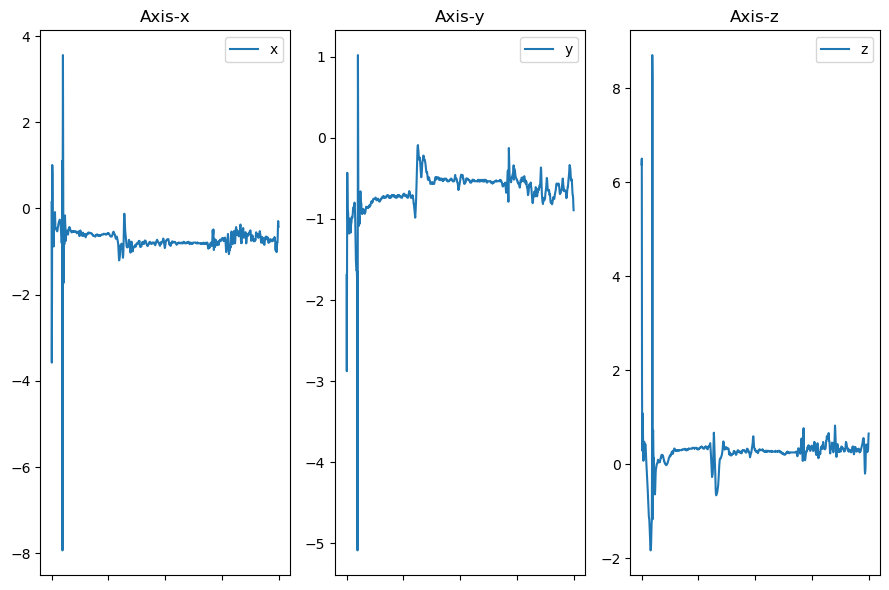

In [15]:
filename = "data/Example/P01_wrist100.csv"

# Read the file
data = pd.read_csv(filename)

plot_xyz(data)